# Assignment 2 2AMM10 2023-2024

## Group: [Fill in your group name]
### Member 1: [Fill in your name]
### Member 2: [Fill in your name]
### Member 3: [Fill in your name]

We need to install some specific libraries. The cell below installs torch_geometric for torch 2.6.0+cu124. In case the current version of torch is different, check [here](https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html) to see which versions (of both libraries) you should install. You might also need to install an old version of torch from [here](https://pytorch.org/get-started/previous-versions/)

**Note:** Do not install pyg_lib from the optional dependencies

In [29]:
pip show torch

Name: torch
Version: 2.6.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: c:\Users\20182672\AppData\Local\anaconda3\envs\MLEngineering\Lib\site-packages
Requires: filelock, fsspec, jinja2, networkx, setuptools, sympy, typing-extensions
Required-by: accelerate, flair, openml-pytorch, pytorch-lightning, pytorch_revgrad, torchmetrics, torchvision, transformer-smaller-training-vocab
Note: you may need to restart the kernel to use updated packages.


In [30]:
import pickle
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
import matplotlib.pyplot as plt

#added by user
import torch
from torch_geometric.data import Data
#from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import math
from torch_geometric.loader import DataLoader

In [31]:
with open('pos_data.pkl', 'rb') as f:
    pos_data = pickle.load(f)

with open('type_data.pkl', 'rb') as f:
    type_data = pickle.load(f)

with open('smiles.pkl', 'rb') as f:
    smiles_data = pickle.load(f)

data_split = np.load('data_split.npz')

train_idxes = data_split['train_idx']
test_idxes = data_split['test_idx']

formation_energy = np.load('formation_energy.npz')

fe = formation_energy['y'] # normalized formation energy
mu = formation_energy['mu']
std = formation_energy['sigma']

Length of data
pos_data: 129012, type_data: 129012, smiles: 129012
Idxes
train: 119012, test: 10000, sum: 129012
5


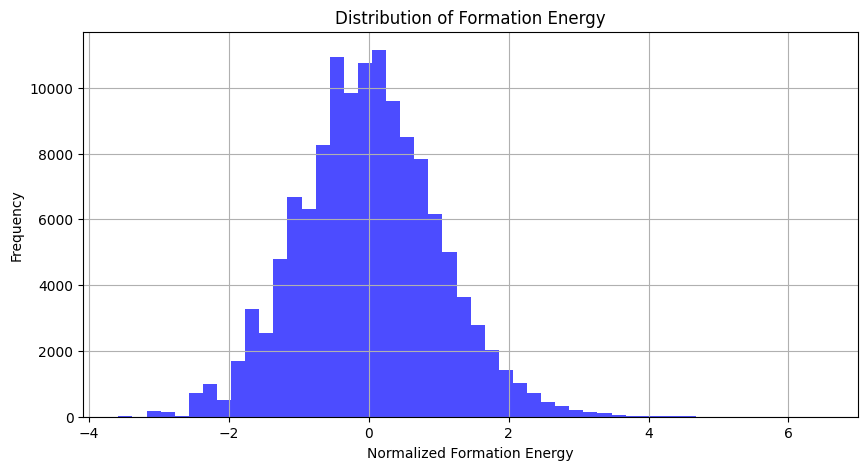

Maximum formation energy: 6.49253511428833
Minimum formation energy: -3.5815374851226807


In [32]:
# shapes of lists
print("Length of data")
print(f"pos_data: {len(pos_data)}, type_data: {len(type_data)}, smiles: {len(smiles_data)}")
print("Idxes")
print(f"train: {len(train_idxes)}, test: {len(test_idxes)}, sum: {len(train_idxes) + len(test_idxes)}")
# print statements
print(pos_data[0].shape[0])

# Visualize fe
plt.figure(figsize=(10, 5))
plt.hist(fe, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Formation Energy')
plt.xlabel('Normalized Formation Energy')
plt.ylabel('Frequency')
plt.grid()
plt.show()
print(f"Maximum formation energy: {np.max(fe)}")
print(f"Minimum formation energy: {np.min(fe)}")


In [33]:
# Flatten the list of atom types and find unique values
unique_atom_types = np.unique(np.concatenate(type_data))

print(f"Number of unique atom types: {len(unique_atom_types)}")
print(f"Unique atom types: {unique_atom_types}")

# This influence the number of atoms types
atom_type_mapping = {1: 0, 6: 1, 7: 2, 8: 3, 9: 4}
type_data_mapped = [
    torch.tensor([atom_type_mapping[atom.item()] for atom in molecule], dtype=torch.long)
    for molecule in type_data
]

# Update num_atom_types
num_atom_types = len(atom_type_mapping)
print(f"Updated number of atom types: {num_atom_types}")

# We want to create embeddings fo each atom type, since we thus only have five we must adjust the indexing such that the embedding can do that. 
# Originally setting at 5 would give an out of bound error because of the index.

Number of unique atom types: 5
Unique atom types: [1 6 7 8 9]
Updated number of atom types: 5


In [34]:
def at_number_to_atom_name(at_number):
    if at_number == 6:
        return 'C'
    elif at_number == 1:
        return 'H'
    elif at_number == 7:
        return 'N'
    elif at_number == 8:
        return 'O'
    elif at_number == 9:
        return 'F'
    elif at_number == 16:
        return 'S'
    else:
        return 'Unknown'

def inspect_structure(idx):
    smile = smiles_data[idx]
    pos = pos_data[idx]
    typ = type_data[idx]

    header = f"{'Atom':^5}│{'Number':^6}│{'x':^10}│{'y':^10}│{'z':^10}"
    line   = "─────┼──────┼──────────┼──────────┼──────────"
    print(header)
    print(line)

    for atom_num, (x, y, z) in zip(typ, pos):
        atom_sym = at_number_to_atom_name(atom_num)
        print(f"{atom_sym:^5}│{atom_num:^6}│{x:>10.3f}│{y:>10.3f}│{z:>10.3f}")
    print("")
    print("")
    print(f'SMILE: {smile}')
    print("")
    print("")
    print(f'Formation Energy: {fe[idx]*std + mu:.3f}')
    print(f'Formation Energy (normalized): {fe[idx]:.5f}')
    mol = Chem.MolFromSmiles(smile)
    if mol:
        # RDKit prefers 2‑D coordinates for nice depictions
        Chem.AllChem.Compute2DCoords(mol)
        img = Draw.MolToImage(mol, size=(300, 300))

        # Display with matplotlib (works both in notebooks and scripts)
        plt.figure(figsize=(3, 3))
        plt.axis('off')
        plt.imshow(img)
        plt.show()

Atom │Number│    x     │    y     │    z     
─────┼──────┼──────────┼──────────┼──────────
  C  │  6   │    -0.061│     1.442│     0.055
  N  │  7   │     0.012│    -0.006│    -0.028
  C  │  6   │    -1.262│    -0.708│    -0.100
  C  │  6   │    -1.061│    -2.162│    -0.507
  C  │  6   │     0.112│    -2.709│     0.285
  O  │  8   │     1.294│    -1.960│    -0.000
  C  │  6   │     1.254│    -0.598│    -0.019
  O  │  8   │     2.294│     0.015│    -0.041
  H  │  1   │     0.951│     1.836│     0.126
  H  │  1   │    -0.551│     1.857│    -0.835
  H  │  1   │    -0.638│     1.750│     0.937
  H  │  1   │    -1.773│    -0.655│     0.875
  H  │  1   │    -1.906│    -0.189│    -0.821
  H  │  1   │    -1.969│    -2.740│    -0.312
  H  │  1   │    -0.836│    -2.233│    -1.576
  H  │  1   │    -0.095│    -2.672│     1.364
  H  │  1   │     0.350│    -3.741│     0.019


SMILE: CN1CCCOC1=O


Formation Energy: -70.755
Formation Energy (normalized): 0.52656


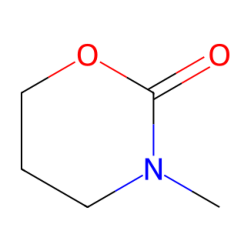

In [35]:
# methane
# Note how methane has a relatively high formation energy (compared to QM9)
# This correlates with lower thermodynamic stability and higher reactivity
# For example, methane readily burns in oxygen (CH₄ + 2O₂ → CO₂ + 2H₂O)
inspect_structure(12000)

Atom │Number│    x     │    y     │    z     
─────┼──────┼──────────┼──────────┼──────────
  C  │  6   │    -0.513│     1.426│    -0.027
  C  │  6   │     0.062│     0.013│     0.001
  C  │  6   │     1.167│    -0.244│    -1.036
  O  │  8   │     1.913│    -1.383│    -0.548
  C  │  6   │     1.661│    -1.568│     0.764
  O  │  8   │     2.088│    -2.488│     1.405
  C  │  6   │     0.746│    -0.457│     1.298
  C  │  6   │     1.605│     0.607│     1.999
  O  │  8   │    -0.190│    -1.008│     2.201
  H  │  1   │     0.261│     2.184│     0.125
  H  │  1   │    -0.993│     1.629│    -0.990
  H  │  1   │    -1.269│     1.548│     0.754
  H  │  1   │    -0.746│    -0.706│    -0.178
  H  │  1   │     0.789│    -0.501│    -2.027
  H  │  1   │     1.852│     0.607│    -1.131
  H  │  1   │     2.307│     1.097│     1.315
  H  │  1   │     0.956│     1.367│     2.440
  H  │  1   │     2.184│     0.137│     2.799
  H  │  1   │     0.266│    -1.733│     2.653


SMILE: C[C@H]1COC(=O)[C@]1(C)O



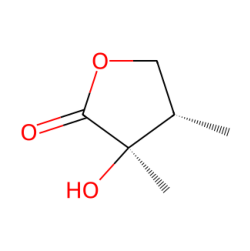

In [36]:
# random structure
inspect_structure(np.random.choice(range(len(smiles_data))))

In [37]:
# For the pos data check max amount of atoms. Might be relevant for hyperparameters but do not know that yet. 
def max_atoms_in_pos_data():
    max_atoms = 0
    for pos in pos_data:
        if pos.shape[0] > max_atoms:
            max_atoms = pos.shape[0]
    return max_atoms

print(f"Maximum number of atoms in pos_data: {max_atoms_in_pos_data()}")

Maximum number of atoms in pos_data: 29


## Task 1

In [38]:
# This I have not checked yet. The code seems to work fine. The cutoff in literature is most about A something.
def build_edges_molecule(positions, cutoff):
    """
    Given a single molecule's atom positions (Nx3 tensor or list of N 3D coords),
    returns edge_index suitable for SchNet input.
    """
    if not isinstance(positions, torch.Tensor):
        positions = torch.tensor(positions, dtype=torch.float32)

    num_atoms = positions.size(0) # positions is here the molecule and those the shape of the tensor
    list_from = []
    list_to = []

    for i in range(num_atoms):
        for j in range(num_atoms):
            if i == j:
                continue
            dist = torch.norm(positions[i] - positions[j])
            if dist < cutoff:
                list_from.append(i)
                list_to.append(j)

    edge_index = torch.tensor([list_from, list_to], dtype=torch.long)
    return edge_index

def build_edges_all(pos_data, cutoff):
    """
    Build edge indices for all molecules in pos_data
    """
    edge_indices = []

    for molecule in pos_data: # each molecule in the pos_data can consists of several atoms (max 29 in data)
        edge_index = build_edges_molecule(molecule, cutoff=cutoff)
        edge_indices.append(edge_index)

    return edge_indices # alist of tensors of shape [2, E] where E is the number of edges in each molecule


In [39]:
# # Perform data analysis on build_edges_all for different cutoffs
# def analyze_edges_by_cutoff(pos_data, cutoffs):
#     """
#     Performs data analysis on edge creation for a list of cutoffs.
#     Prints information about the number of edges generated for each cutoff.
#     """
#     print("--- Edge Analysis by Cutoff ---")
#     for cutoff in cutoffs:
#         print(f"\nAnalyzing cutoff: {cutoff}")
#         edge_counts = []
#         for molecule_pos in pos_data:
#             edge_index = build_edges_molecule(molecule_pos, cutoff=cutoff)
#             edge_counts.append(edge_index.size(1)) # Number of edges is the second dimension

#         total_edges = sum(edge_counts)
#         avg_edges_per_molecule = total_edges / len(pos_data)
#         max_edges_in_molecule = max(edge_counts)

#         print(f"  Total number of edges across all molecules: {total_edges}")
#         print(f"  Average number of edges per molecule: {avg_edges_per_molecule:.2f}")
#         print(f"  Maximum number of edges in a single molecule: {max_edges_in_molecule}")

# # Example usage:
# # Define a list of cutoffs to analyze
# cutoffs_to_analyze = [1.0, 1.5, 2.0, 2.5, 3.0] # Example cutoffs

# # Run the analysis
# analyze_edges_by_cutoff(pos_data, cutoffs_to_analyze)

--- Edge Analysis by Cutoff ---

Analyzing cutoff: 1.0
  Total number of edges across all molecules: 100632
  Average number of edges per molecule: 0.78
  Maximum number of edges in a single molecule: 8

Analyzing cutoff: 1.5
  Total number of edges across all molecules: 3715924
  Average number of edges per molecule: 28.80
  Maximum number of edges in a single molecule: 46

Analyzing cutoff: 2.0
  Total number of edges across all molecules: 6122042
  Average number of edges per molecule: 47.45
  Maximum number of edges in a single molecule: 94

Analyzing cutoff: 2.5
  Total number of edges across all molecules: 12977958
  Average number of edges per molecule: 100.59
  Maximum number of edges in a single molecule: 198

Based on this I do think that another cutoff might be relevant?

In [40]:
#edge_indices = build_edges_all(pos_data, cutoff=1.5)

# Save
#torch.save(edge_indices, "edges.pt")

# Load
edge_indices = torch.load("edges.pt")

pos_data = [torch.tensor(mol, dtype=torch.float32) for mol in pos_data]
type_data = [torch.tensor(mol, dtype=torch.long) for mol in type_data]

# Goal of this code is to create for all the three aspects of the data a list of tensors
# Think about whether this is correctly used

In [41]:
# Perform data on edge indices size, shape and type
print(f"Edge indices length: {len(edge_indices)}")
# This makes sense sinc for each molecule we should get a tensor of the edges

Edge indices length: 129012


In [42]:
# This is required to convert the data into dataloaders later
# class MoleculeDataset(torch.utils.data.Dataset):
#     def __init__(self, atom_types_list, positions_list, edge_indices_list, targets):
#         self.atom_types_list = atom_types_list
#         self.positions_list = positions_list
#         self.edge_indices_list = edge_indices_list
#         self.targets = targets

#     def __len__(self):
#         return len(self.targets)

#     def __getitem__(self, idx):
#         return (
#             self.atom_types_list[idx],
#             self.positions_list[idx],
#             self.edge_indices_list[idx],
#             self.targets[idx],
#         )

class MoleculeDataset(torch.utils.data.Dataset):
    def __init__(self, atom_types_list, positions_list, edge_indices_list, targets):
        self.atom_types_list = atom_types_list
        self.positions_list = positions_list
        self.edge_indices_list = edge_indices_list
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        # Create a torch_geometric.data.Data object for each molecule
        data = Data(
            x=self.atom_types_list[idx],  # Node features (atom types)
            pos=self.positions_list[idx],  # Node positions
            edge_index=self.edge_indices_list[idx],  # Edge indices
            y=self.targets[idx]  # Target value
        )
        return data

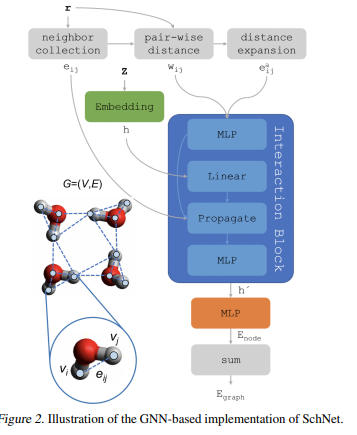

In [43]:
# also based upon https://arxiv.org/abs/1706.08566 the original SchNet paper

class RBFExpansion(nn.Module):
    """
    Radial Basis Function Expansion is a way to transform distances
    into a set of features that can be used in neural networks. The idea is that it must become higher dimensional to be more expressive.
    This uses a Gaussian RBF, like in SchNet.
    """
    def __init__(self, num_rbf=300, cutoff=1.5, gamma=10.0):
        super().__init__()
        centers = torch.linspace(0, cutoff, num_rbf) #create RBF centers, creates num_rbf values from 0 to cutoff
        self.register_buffer('centers', centers) #for GPU compatibility
        self.gamma = gamma # larger gamma means sharper peaks in the RBF

    def forward(self, distances):
        return torch.exp(-self.gamma * (distances.unsqueeze(1) - self.centers) ** 2)

class ShiftedSoftplus(nn.Module):
    def forward(self, x):
        return F.softplus(x) - math.log(2)
    
class ReadoutMLP(nn.Module):
    def __init__(self, hidden_dim=64, mid_dim=32):
        super().__init__()
        self.atom_dense1 = nn.Linear(hidden_dim, mid_dim)  # atom-wise layer
        self.activation = ShiftedSoftplus()                # shifted softplus orignal paper could consider SiLU
        self.atom_dense2 = nn.Linear(mid_dim, 1)           # atom-wise layer to scalar
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, h, batch_idx):
        # Apply atom-wise layers
        h = self.atom_dense1(h)
        h = self.activation(h)
        #h = self.dropout(h) # added dropout compared to original paper
        h = self.atom_dense2(h)
        h = h.squeeze(-1)  # ensure h is 1D per atom

        # Pooling over atoms to get per-molecule energy
        num_graphs = batch_idx.max().item() + 1
        energy = torch.zeros(num_graphs, device=h.device)
        energy = energy.index_add(0, batch_idx, h)  # sum pooling

        return energy

class MLP(nn.Module):
    """
    simple Multi-Layer Perceptron (MLP) with Shifted Softplus activations.
    """
    def __init__(self, in_dim, out_dim, hidden_dim=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            ShiftedSoftplus(), #based on original paper
            nn.Linear(hidden_dim, out_dim),
            ShiftedSoftplus(), #based on original paper
            #nn.Linear(hidden_dim, out_dim) in orignal paper there is no linear layer after the last actiation
        )

    def forward(self, x):
        return self.model(x)
    
# This interaction block is updated compared to the previous implementation now the rbf is included in the interaction block each time
class InteractionBlock(nn.Module):
    def __init__(self, hidden_dim, num_rbf, cutoff):
        super().__init__()
        self.rbf_layer = RBFExpansion(num_rbf, cutoff)  
        self.filter_net = MLP(num_rbf, hidden_dim) # learns filters
        self.atom_dense = nn.Linear(hidden_dim, hidden_dim)
        self.cutoff = cutoff
        self.post_dense1 = nn.Linear(hidden_dim, hidden_dim)
        self.activation = ShiftedSoftplus()
        self.post_dense2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, h, edge_index, positions):
        # This order of source and target is reversed here
        source, target = edge_index # source is j, target is i
        distances = torch.norm(positions[source] - positions[target], dim=1)

        # Compute RBF and filters
        rbf = self.rbf_layer(distances)
        f_ij = self.filter_net(rbf) # these are the filters

        # Cosine cutoff; consider with or without 0.5 infront
        cutoff_weight = 0.5 * torch.cos((torch.pi * distances) / (2 * self.cutoff))

        # Message passing from source to target
        h_proj = self.atom_dense(h[source])
        m_ij = f_ij * h_proj * cutoff_weight.unsqueeze(-1)
        #m_ij = f_ij * h_proj # messages

        agg = torch.zeros_like(h)
        agg.index_add_(0, target, m_ij)

        # Atomwise layers
        out = self.post_dense1(agg)
        out = self.activation(out)
        #out = self.dropout(out)
        out = self.post_dense2(out)
        return h + out


class SchNetLightning(pl.LightningModule):
    def __init__(self, num_atom_types, hidden_dim=128, num_rbf=64, num_blocks=5, lr=1e-3, cutoff=3.0):
        super().__init__()
        self.save_hyperparameters()
        self.embedding = nn.Embedding(num_atom_types, hidden_dim)
        self.interaction_blocks = nn.ModuleList([InteractionBlock(hidden_dim, num_rbf, cutoff) for _ in range(num_blocks)])
        self.readout = ReadoutMLP(hidden_dim)
        self.lr = lr
        self.cutoff = cutoff

    def forward(self, atom_types, positions, edge_index, batch_idx):
      h = self.embedding(atom_types)
      for block in self.interaction_blocks:
          h = block(h, edge_index, positions)
      return self.readout(h, batch_idx)
    
    def training_step(self, batch, batch_idx):
      atom_types, positions, edge_index, batch_idx, targets = batch
      preds = self(atom_types, positions, edge_index, batch_idx)
      loss = F.mse_loss(preds, targets)
      self.log("train_loss", loss, batch_size=batch_size)
      return loss

    def validation_step(self, batch, batch_idx):
      atom_types, positions, edge_index, batch_idx, targets = batch
      preds = self(atom_types, positions, edge_index, batch_idx)
      loss = F.mse_loss(preds, targets)
      self.log("val_loss", loss, batch_size=batch_size)
      return loss
    
    def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-5)
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.8, patience=3
      )
      return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss"}}

    def on_validation_epoch_end(self):
      val_loss = self.trainer.callback_metrics.get("val_loss")
      if val_loss is not None:
          print(f"Val Loss   (epoch {self.current_epoch}): {val_loss:.6f}")

    def on_train_epoch_end(self):
      train_loss = self.trainer.callback_metrics.get("train_loss")
      if train_loss is not None:
          print(f"Train Loss (epoch {self.current_epoch}): {train_loss:.6f}")


In [44]:
batch = next(iter(train_loader))
print(batch)
print(batch.x.shape)  # Node features
print(batch.pos.shape)  # Node positions
print(batch.edge_index.shape)  # Edge indices
print(batch.y.shape)  # Targets
print(batch.batch.shape)  # Batch tensor

DataBatch(x=[2291], edge_index=[2, 3720], y=[128], pos=[2291, 3], batch=[2291], ptr=[129])
torch.Size([2291])
torch.Size([2291, 3])
torch.Size([2, 3720])
torch.Size([128])
torch.Size([2291])


In [45]:
batch_size = 128

# #batch function works poorly when data has different lengths, so we need to collate it manually
# def collate_fn(batch):
#     atom_types_list, pos_list, edge_idx_list, targets_list = zip(*batch)

#     atom_types_all = []
#     positions_all = []
#     edge_indices_all = []
#     base_index = 0
#     batch_idx = []

#     for i, (atom_types, pos, edge_idx) in enumerate(zip(atom_types_list, pos_list, edge_idx_list)):
#         n_atoms = atom_types.size(0)

#         atom_types_all.append(atom_types)
#         positions_all.append(pos)
#         batch_idx.append(torch.full((n_atoms,), i, dtype=torch.long))  # keeps track of molecule

#         edge_indices_all.append(edge_idx + base_index)  # shift edge indices for batching
#         base_index += n_atoms

#     atom_types_all = torch.cat(atom_types_all)
#     positions_all = torch.cat(positions_all)
#     edge_indices_all = torch.cat(edge_indices_all, dim=1)
#     batch_idx = torch.cat(batch_idx)
#     targets = torch.stack(targets_list)

#     return atom_types_all, positions_all, edge_indices_all, batch_idx, targets


train_idx, val_idx = train_test_split(train_idxes, test_size=0.2, random_state=0)

# train_dataset = MoleculeDataset(
#     [type_data[i] for i in train_idx],
#     [pos_data[i] for i in train_idx],
#     [edge_indices[i] for i in train_idx],
#     torch.tensor([fe[i] for i in train_idx], dtype=torch.float32)
# )

# val_dataset = MoleculeDataset(
#     [type_data[i] for i in val_idx],
#     [pos_data[i] for i in val_idx],
#     [edge_indices[i] for i in val_idx],
#     torch.tensor([fe[i] for i in val_idx], dtype=torch.float32)
# )

# test_dataset = MoleculeDataset(
#     [type_data[i] for i in test_idxes],
#     [pos_data[i] for i in test_idxes],
#     [edge_indices[i] for i in test_idxes],
#     torch.tensor([fe[i] for i in test_idxes], dtype=torch.float32)
# )

# New form of the type_data_mapped should be correct but still feel a bit uncertain about it
train_dataset = MoleculeDataset(
    [type_data_mapped[i] for i in train_idx],
    [pos_data[i] for i in train_idx],
    [edge_indices[i] for i in train_idx],
    torch.tensor([fe[i] for i in train_idx], dtype=torch.float32)
)

val_dataset = MoleculeDataset(
    [type_data_mapped[i] for i in val_idx],
    [pos_data[i] for i in val_idx],
    [edge_indices[i] for i in val_idx],
    torch.tensor([fe[i] for i in val_idx], dtype=torch.float32)
)

test_dataset = MoleculeDataset(
    [type_data_mapped[i] for i in test_idxes],
    [pos_data[i] for i in test_idxes],
    [edge_indices[i] for i in test_idxes],
    torch.tensor([fe[i] for i in test_idxes], dtype=torch.float32)
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [51]:
# List of hyperparameters

hidden_dim = 256
num_rbf = 64 # in origal it was rbf300
num_blocks = 5
cutoff = 1.5 # it does not make sen to change the cutoff as long as i dont rerun the edge code
lr = 1e-4
weight_decay = 1e-6
max_epochs = 50
patience = 5
#num_atom_types = 10 # based on 5 unique atoms
gamma = 10.0

In [52]:
# sample = next(iter(train_loader))
# atom_types, pos, edge_idx, batch, targets = sample

# print("Atom types shape:", atom_types.shape)
# print("Position shape:", pos.shape)
# print("Edge index shape:", edge_idx.shape)
# print("Batch shape:", batch.shape)
# print("Targets shape:", targets.shape)

# print("Atom types unique:", atom_types.unique())
# assert atom_types.max() < num_atom_types, "Found invalid atom type index!"


In [53]:
# import matplotlib.pyplot as plt
# import torch
# import torch.nn as nn

# # Code to train the model
# def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-3, device='cpu'):
#     model.to(device)
#     criterion = nn.MSELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#     train_losses = []
#     val_losses = []

#     for epoch in range(num_epochs):
#         # Training step
#         model.train()
#         total_loss = 0.0

#         for batch in train_loader:
#             atom_types, positions, edge_index, batch_idx, targets = batch
#             atom_types = atom_types.to(device)
#             positions = positions.to(device)
#             edge_index = edge_index.to(device)
#             batch_idx = batch_idx.to(device)
#             targets = targets.to(device)

#             optimizer.zero_grad()
#             outputs = model(atom_types, positions, edge_index, batch_idx)
#             loss = criterion(outputs.squeeze(), targets)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()

#         avg_loss = total_loss / len(train_loader)
#         train_losses.append(avg_loss)
#         print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.4f}")

#         # Validation step
#         model.eval()
#         val_loss = 0.0
#         with torch.no_grad():
#             for batch in val_loader:
#                 atom_types, positions, edge_index, batch_idx, targets = batch
#                 atom_types = atom_types.to(device)
#                 positions = positions.to(device)
#                 edge_index = edge_index.to(device)
#                 batch_idx = batch_idx.to(device)
#                 targets = targets.to(device)

#                 outputs = model(atom_types, positions, edge_index, batch_idx)
#                 loss = criterion(outputs.squeeze(), targets)
#                 val_loss += loss.item()

#         avg_val_loss = val_loss / len(val_loader)
#         val_losses.append(avg_val_loss)
#         print(f"Validation Loss: {avg_val_loss:.4f}")

#     # Plot training and validation loss curves
#     plt.figure(figsize=(10, 6))
#     plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
#     plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.title('Training and Validation Loss Curves')
#     plt.legend()
#     plt.grid()
#     plt.show()

In [54]:
# Code to train the model
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-3, device='cpu'):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training step
        model.train()
        total_loss = 0.0

        for batch in train_loader:
            # Move the entire batch to the device
            batch = batch.to(device)

            optimizer.zero_grad()
            # Extract data from the batch
            outputs = model(batch.x, batch.pos, batch.edge_index, batch.batch)
            loss = criterion(outputs.squeeze(), batch.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.4f}")

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                # Move the entire batch to the device
                batch = batch.to(device)

                # Extract data from the batch
                outputs = model(batch.x, batch.pos, batch.edge_index, batch.batch)
                loss = criterion(outputs.squeeze(), batch.y)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.4f}")

    # Plot training and validation loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid()
    plt.show()

Epoch 1/50, Training Loss: 0.2293
Validation Loss: 0.2098
Epoch 2/50, Training Loss: 0.1955
Validation Loss: 0.2050
Epoch 3/50, Training Loss: 0.1929
Validation Loss: 0.1997
Epoch 4/50, Training Loss: 0.1909
Validation Loss: 0.2021
Epoch 5/50, Training Loss: 0.1909
Validation Loss: 0.2063
Epoch 6/50, Training Loss: 0.1896
Validation Loss: 0.1960
Epoch 7/50, Training Loss: 0.1895
Validation Loss: 0.1975
Epoch 8/50, Training Loss: 0.1885
Validation Loss: 0.2022
Epoch 9/50, Training Loss: 0.1889
Validation Loss: 0.1950
Epoch 10/50, Training Loss: 0.1880
Validation Loss: 0.1965
Epoch 11/50, Training Loss: 0.1880
Validation Loss: 0.1946
Epoch 12/50, Training Loss: 0.1869
Validation Loss: 0.2072
Epoch 13/50, Training Loss: 0.1874
Validation Loss: 0.1938
Epoch 14/50, Training Loss: 0.1860
Validation Loss: 0.2137
Epoch 15/50, Training Loss: 0.1864
Validation Loss: 0.1956
Epoch 16/50, Training Loss: 0.1859
Validation Loss: 0.2011
Epoch 17/50, Training Loss: 0.1860
Validation Loss: 0.2046
Epoch 

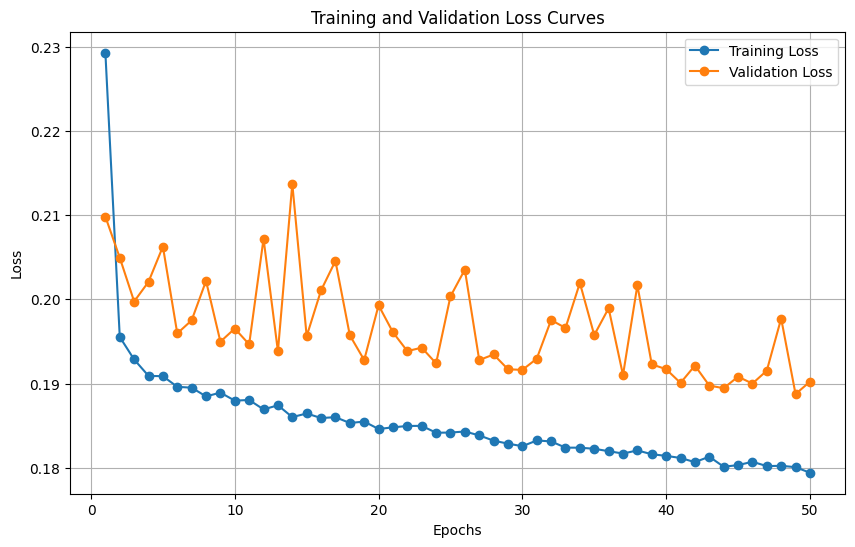

In [55]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SchNetLightning(num_atom_types=num_atom_types, hidden_dim=hidden_dim, num_blocks=num_blocks, lr=lr)
train_model(model, train_loader, val_loader, num_epochs=max_epochs, learning_rate=lr, device=device)

In [56]:
# from pytorch_lightning import Trainer
# from pytorch_lightning.callbacks import EarlyStopping

# early_stop_callback = EarlyStopping(
#     monitor='val_loss',      # metric to monitor
#     patience=patience,              # epochs to wait for improvement
#     verbose=True,
#     mode='min'               # minimize the val_loss
# )

# trainer = Trainer(
#     max_epochs=max_epochs,
#     accelerator='cpu',       # or 'gpu'
#     callbacks=[early_stop_callback],
#     enable_progress_bar=True # shows loss after each epoch
# )
# model = SchNetLightning(num_atom_types=num_atom_types, hidden_dim=hidden_dim, num_blocks=num_blocks,lr=lr)
# trainer.fit(model, train_loader, val_loader)




In [58]:
# Set model to evaluation mode
model.eval()
test_losses = []
test_mae = []

with torch.no_grad():
    for batch in test_loader:
        # Move the entire batch to the device
        batch = batch.to(device)

        # Extract predictions from the model
        preds = model(batch.x, batch.pos, batch.edge_index, batch.batch)

        # Denormalize predictions and targets
        original_preds = preds * std + mu
        original_targets = batch.y * std + mu

        # Compute losses
        mse_loss = F.mse_loss(original_preds, original_targets)
        mae_loss = F.l1_loss(original_preds, original_targets)

        # Append losses
        test_losses.append(mse_loss.item())
        test_mae.append(mae_loss.item())

# Compute mean losses
mean_test_loss = sum(test_losses) / len(test_losses)
mean_test_mae = sum(test_mae) / len(test_mae)

print(f"Test MSE loss (original scale): {mean_test_loss:.4f}")
print(f"Test MAE loss (original scale): {mean_test_mae:.4f}")

Test MSE loss (original scale): 19.7798
Test MAE loss (original scale): 2.7027


In [ ]:
# Save the model
torch.save(model.state_dict(), "schnet_model.pth")
print("Model saved successfully!")

## Task 2

## Task 3

In [ ]:
def is_valid_smiles(smiles):
    if smiles is None:
        return False
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None
    except:
        return False

def canonicalize(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.MolToSmiles(mol, canonical=True)
        return 'None'
    except:
        return 'None'

In [ ]:
canonicalize("COO"), canonicalize("O(C)O")

('COO', 'COO')

In [ ]:
is_valid_smiles("COO"), is_valid_smiles("O(C)O"), is_valid_smiles("C##")

(True, True, False)